# 서브그룹 분석


### 라이브러리 및 데이터셋 호출

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
# df=pd.read_csv("../real_data/공시지가_전처리.csv")
df=pd.read_csv("공시지가_전처리.csv")

### 전처리

In [12]:
def assign_region_group(sido_name):
    if sido_name == '서울특별시':
        return '서울'
    elif sido_name in ['경기도', '인천광역시']:
        return '수도권'
    elif sido_name in ['부산광역시', '대구광역시', '대전광역시',
                       '광주광역시', '울산광역시', '세종특별자치시']:
        return '비수도권_광역시_및_특별시'
    else:
        return '비수도권 지역'

df['지역그룹'] = df['시도명'].apply(assign_region_group)

df_seoul = df[df['지역그룹'] == '서울']
df_sudogwon = df[df['지역그룹'] == '수도권']
df_non_sudogwon = df[df['지역그룹'] == '비수도권_광역시_및_특별시']
df_rural = df[df['지역그룹'] == '비수도권 지역']

df = df.drop(columns=['지역그룹', '시도명'])


In [ ]:
# 그룹 데이터프레임 딕셔너리
group_dfs = {
    "seoul": df_seoul,
    "sudogwon": df_sudogwon,
    "non_sudogwon": df_non_sudogwon,
    "rural": df_rural
}

# 타겟 변수명
target_col = '내년_공시지가'

# 결과 저장용 딕셔너리
split_data = {}

# 그룹별 train/test 분할
for name, group_df in group_dfs.items():
    X = group_df.drop(columns=[target_col])
    y = group_df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    split_data[f"x_train_{name}"] = X_train
    split_data[f"x_test_{name}"] = X_test
    split_data[f"y_train_{name}"] = y_train
    split_data[f"y_test_{name}"] = y_test

globals().update(split_data)

In [ ]:
region_keys = ['seoul', 'sudogwon', 'non_sudogwon', 'rural']

# 최종 결과 저장용
final_encoded_dfs = {}

for region in region_keys:
    # 1. 원본 데이터 불러오기
    x_train = globals()[f'x_train_{region}']
    x_test = globals()[f'x_test_{region}']

    # 2. 면적 정규화
    scaler = MinMaxScaler()
    area_train_scaled = scaler.fit_transform(x_train[['면적']])
    area_test_scaled = scaler.transform(x_test[['면적']])

    # 3. 범주형 변수 인코딩
    categorical_cols = x_train.drop(columns=['면적']).columns.tolist()
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_train_cat_encoded = encoder.fit_transform(x_train[categorical_cols])
    X_test_cat_encoded = encoder.transform(x_test[categorical_cols])
    encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

    # 4. 최종 DataFrame 생성 (면적+ 범주형 변수 합치기)
    X_train_final = pd.DataFrame(
        np.concatenate([area_train_scaled, X_train_cat_encoded], axis=1),
        columns=['면적'] + encoded_feature_names.tolist(),
        index=x_train.index
    )
    X_test_final = pd.DataFrame(
        np.concatenate([area_test_scaled, X_test_cat_encoded], axis=1),
        columns=['면적'] + encoded_feature_names.tolist(),
        index=x_test.index
    )

    # 5. 전역 변수로 저장
    globals()[f'x_train_{region}'] = X_train_final
    globals()[f'x_test_{region}'] = X_test_final
    final_encoded_dfs[region] = (X_train_final, X_test_final)

    print(f"{region}: 최종 전처리 완료 ✅")



seoul: 최종 전처리 완료 ✅
sudogwon: 최종 전처리 완료 ✅
non_sudogwon: 최종 전처리 완료 ✅
rural: 최종 전처리 완료 ✅


In [15]:
region_keys = ['seoul', 'sudogwon', 'non_sudogwon', 'rural']
target_scalers = {}

for region in region_keys:
    # y 정규화
    y_train = globals()[f'y_train_{region}']
    y_test = globals()[f'y_test_{region}']

    scaler_target = MinMaxScaler()
    y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))

    # 전역 변수로 저장
    globals()[f'y_train_{region}'] = y_train_scaled
    globals()[f'y_test_{region}'] = y_test_scaled
    target_scalers[region] = scaler_target

    # X 컬럼 이름 정리
    for split in ['train', 'test']:
        X = globals()[f'x_{split}_{region}']
        X.columns = X.columns.str.replace(',', '_')
        X.columns = X.columns.str.replace(' ', '_')
        globals()[f'x_{split}_{region}_encoded'] = X

    print(f"{region}: y 정규화 + X 컬럼 정리 완료 ✅")


seoul: y 정규화 + X 컬럼 정리 완료 ✅
sudogwon: y 정규화 + X 컬럼 정리 완료 ✅
non_sudogwon: y 정규화 + X 컬럼 정리 완료 ✅
rural: y 정규화 + X 컬럼 정리 완료 ✅


In [ ]:
# 지역 키 목록
region_keys = ['seoul', 'sudogwon', 'non_sudogwon', 'rural']

# 제거된 변수 저장용 딕셔너리
vif_drop_cols = {}

for region in region_keys:
    X_train = globals()[f'x_train_{region}']
    X_test = globals()[f'x_test_{region}']

    # VIF 계산
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    high_vif_cols = vif_data[vif_data["VIF"] > 10]["feature"].tolist()

    # 변수 제거 VIF가 10 이상인 변수 삭제
    X_train_reduced = X_train.drop(columns=high_vif_cols)
    X_test_reduced = X_test.drop(columns=high_vif_cols)

    # 전역 변수로 저장
    globals()[f'x_train_{region}'] = X_train_reduced
    globals()[f'x_test_{region}'] = X_test_reduced
    vif_drop_cols[region] = high_vif_cols

    print(f"{region}: {len(high_vif_cols)}개 변수 제거됨 ✅")

# 제거된 변수 목록 확인
vif_drop_cols


seoul: 23개 변수 제거됨 ✅
sudogwon: 31개 변수 제거됨 ✅
non_sudogwon: 28개 변수 제거됨 ✅
rural: 32개 변수 제거됨 ✅


{'seoul': ['지목_대',
  '지목_임야',
  '지목_전',
  '용도지역1_일반상업지역',
  '용도지역1_제1종일반주거지역',
  '용도지역1_제2종일반주거지역',
  '용도지역1_제3종일반주거지역',
  '이용상황_단독주택',
  '이용상황_상업용',
  '이용상황_자연림',
  '이용상황_전',
  '이용상황_주상용',
  '주위환경_기타',
  '주위환경_농촌·경작지대',
  '주위환경_산림지대',
  '주위환경_상업지대',
  '주위환경_주거지대',
  '지세명_완경사지',
  '지세명_평지',
  '기타제한_교육환경보호구역',
  '기타제한_기타',
  '기타제한_지구단위계획구역',
  '임야구분_비임야'],
 'sudogwon': ['지목_답',
  '지목_대',
  '지목_임야',
  '지목_전',
  '이용상황_단독주택',
  '이용상황_답',
  '이용상황_상업용',
  '이용상황_자연림',
  '이용상황_전',
  '이용상황_주상용',
  '주위환경_농촌·경작지대',
  '주위환경_산림지대',
  '주위환경_상업지대',
  '주위환경_주거지대',
  '지세명_급경사지',
  '지세명_완경사지',
  '지세명_평지',
  '도로교통_맹지',
  '도로교통_세로(가)',
  '도로교통_세로(불)',
  '도로교통_소로한면',
  '용도지구_미지정',
  '농지구분_비농지',
  '기타제한_교육환경보호구역',
  '기타제한_군사기지및군사시설보호구역_비행안전구역',
  '기타제한_기타',
  '기타제한_문화재보호구역',
  '기타제한_지구단위계획구역',
  '기타제한_특별대책지역',
  '기타제한_허가구역',
  '임야구분_비임야'],
 'non_sudogwon': ['지번구분_2',
  '지목_답',
  '지목_대',
  '지목_임야',
  '지목_전',
  '용도지역1_제2종일반주거지역',
  '이용상황_단독주택',
  '이용상황_답',
  '이용상황_상업용',
  '이용상황_자연림',
  '이용상황_전',
  '이용상황_주상용',

In [20]:
import pickle

region_keys = ['seoul', 'sudogwon', 'non_sudogwon', 'rural']

for region in region_keys:
    x_train = globals()[f'x_train_{region}']
    x_test = globals()[f'x_test_{region}']
    y_train = globals()[f'y_train_{region}']
    y_test = globals()[f'y_test_{region}']

    filename = f"{region}_split_data.pkl"
    with open(filename, "wb") as f:
        pickle.dump((x_train, x_test, y_train, y_test), f)

    print(f"{filename} 저장 완료 ✅")


seoul_split_data.pkl 저장 완료 ✅
sudogwon_split_data.pkl 저장 완료 ✅
non_sudogwon_split_data.pkl 저장 완료 ✅
rural_split_data.pkl 저장 완료 ✅


### LGBM 모델 랜덤 서치

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 지역 키 목록
region_keys = ['seoul', 'sudogwon', 'non_sudogwon', 'rural']

# 하이퍼파라미터 후보
param_dist = {
    "num_leaves": [15, 31, 63], # 트리 하나에서 만들 수 있는 노드 수
    "max_depth": [-1, 5, 10, 20], # 최대 깊이 
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300, 500], # 트리 개수 
    "min_child_samples": [5, 10, 20] # 하나의 리프 노드가 가져야 할 최소 샘플
}

# 결과 저장용 딕셔너리
best_models = {}
rmse_results = {}

for region in region_keys:
    print(f"\n📍 {region} 지역 모델 학습 중...")

    # 데이터 로드
    x_train = globals()[f'x_train_{region}']
    x_test = globals()[f'x_test_{region}']
    y_train = globals()[f'y_train_{region}'].ravel()
    y_test = globals()[f'y_test_{region}'].ravel()

    # 모델 정의 및 랜덤 서치
    lgbm = LGBMRegressor(random_state=42)
    search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_dist,
        n_iter=30,
        scoring='neg_root_mean_squared_error',
        cv=3,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )
    search.fit(x_train, y_train)

    # 최적 모델 저장
    best_model = search.best_estimator_
    best_models[region] = best_model

print("\n📌 지역별 LightGBM 최적 하이퍼파라미터")

for region in region_keys:
    print(f"\n[{region.upper()}]")
    best_model = best_models[region]
    best_params = best_model.get_params()

    for param, value in best_params.items():
        print(f"{param}: {value}")




📍 seoul 지역 모델 학습 중...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 24245, number of used features: 38
[LightGBM] [Info] Start training from score 0.038794

📍 sudogwon 지역 모델 학습 중...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 62961, number of used features: 45
[LightGBM] [Info] Start training from score 0.029399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [ ]:
from sklearn.metrics import r2_score

r2_results = {}

for region in region_keys:
    print(f"\n✅ {region} 지역 성능 평가 중...")

    x_test = globals()[f'x_test_{region}']
    y_test = globals()[f'y_test_{region}']
    scaler = target_scalers[region]  # 정규화에 사용했던 scaler

    # 예측
    preds = best_models[region].predict(x_test)
    globals()[f'preds_{region}'] = preds  # 전역 변수로 저장

    # 역정규화
    y_pred_inverse = scaler.inverse_transform(preds.reshape(-1, 1))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 성능 평가
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)

    rmse_results[region] = rmse
    r2_results[region] = r2

    print(f"   - RMSE: {rmse:,.2f}")
    print(f"   - R²: {r2:.5f}")



✅ seoul 지역 성능 평가 중...
   - RMSE: 5,757,780.24
   - R²: 0.37915

✅ sudogwon 지역 성능 평가 중...
   - RMSE: 750,679.66
   - R²: 0.66781

✅ non_sudogwon 지역 성능 평가 중...
   - RMSE: 1,110,417.36
   - R²: 0.55705

✅ rural 지역 성능 평가 중...
   - RMSE: 217,934.76
   - R²: 0.69049


### 성능 비교 시각화

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 설정 (Windows 기본 폰트)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 1. 데이터 정의
data = {
    "Region": ["seoul", "sudogwon", "non_sudogwon", "rural"],
    "RMSE": [5757780.24, 750679.66, 1110417.36, 217934.76],
    "R2": [0.37915, 0.66781, 0.55705, 0.69049]
}

df = pd.DataFrame(data)



C:\Users\jeongbin\AppData\Local\Temp\ipykernel_17276\2061417874.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Region", y="R2", data=df, palette="Greens_d")


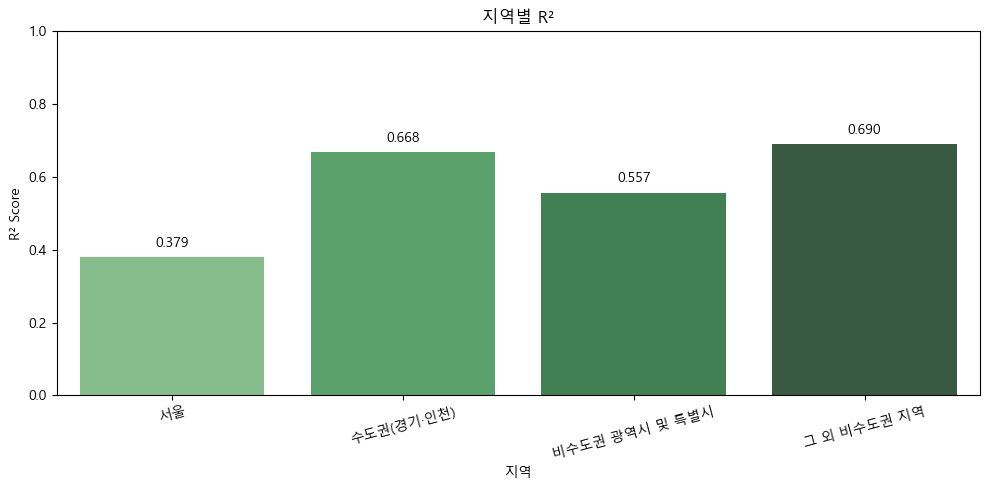

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 (설명형 지역명으로 교체)
data = {
    "Region": [
        "서울", 
        "수도권(경기·인천)", 
        "비수도권 광역시 및 특별시", 
        "그 외 비수도권 지역"
    ],
    "R2": [0.37915, 0.66781, 0.55705, 0.69049]
}

df = pd.DataFrame(data)

# R² 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x="Region", y="R2", data=df, palette="Greens_d")

# 값 라벨 추가
for index, row in df.iterrows():
    plt.text(index, row.R2 + 0.02, f"{row.R2:.3f}", ha='center', va='bottom', fontsize=10)

plt.title("지역별 R²")
plt.ylabel("R² Score")
plt.xlabel("지역")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
